In [2]:
import numpy as np
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
img = Image.open("datasets/images/street.jpg").convert('RGB')
img

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as tf
import torchvision



In [ ]:
# Transform images to tensors using transforms
transforms = tf.Compose([tf.Resize(400), 
                        tf.ToTensor()])
img_tensor = transforms(img)
img_tensor

In [4]:
""" Dimensions of Convolution output
Output = ((Input - kernel_dim + 2 * pad)/ Stride_size) +1
"""
mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

# Display Some
random_sel = mnist_train.sample(8)
image_features = random_sel.drop('label', axis =1)
image_batch = (torch.Tensor(image_features.values / 255.)).reshape((-1, 28, 28))
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)

(-0.5, 241.5, 31.5, -0.5)

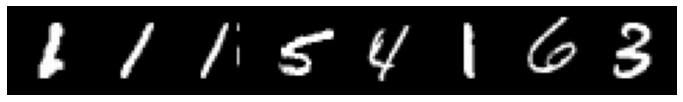

In [7]:
plt.figure (figsize = (12, 12))

plt.imshow(grid.numpy().transpose((1, 2, 0)))

plt.axis('off')

In [8]:
# Create training and test set tensors
mnist_train_features = mnist_train.drop('label', axis =1)
mnist_train_target = mnist_train['label']

mnist_test_features = mnist_test.drop('label', axis =1)
mnist_test_target = mnist_test['label']

X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
x_test_tensor  = torch.tensor(mnist_test_features.values, dtype=torch.float) 

Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
y_test_tensor  = torch.tensor(mnist_test_target.values, dtype=torch.long)

print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [9]:
# Reshape (batch, RGB or grayscale , height, width)/ It is pytorch's shape
X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28)
x_test_tensor = x_test_tensor.reshape(-1, 1, 28, 28)
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [10]:
# Parameters
in_size = 1
hid1_size = 16 #Re-run for 32
hid2_size = 32 #Re-run for 64
out_size = 10
k_conv_size = 5

In [11]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(512, out_size)
        
 
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        
        out = self.layer2(out)
        #print(out.shape)
        
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        
        out = self.fc(out)
        #print(out.shape)
        
        ## F.log_softmax(out, dim=-1)
        
        return out

In [15]:
model = ConvNet()

# Set pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

cpu


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
# All needed tensors for training must be in the device
X_train_tensor = X_train_tensor.to(device)
x_test_tensor  = x_test_tensor.to(device) 

Y_train_tensor = Y_train_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)

In [17]:
learning_rate = 0.001 

#Loss function
criterion = nn.CrossEntropyLoss() 
#nn.NLLLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#optimizer =torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
                    

## Training

In [18]:
num_epochs = 10
loss_values = list()

for epoch in range(1, num_epochs):
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs,Y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        print('Epoch - %d, loss - %0.5f '%(epoch, loss.item()))
        loss_values.append(loss.item())


torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 1, loss - 2.49831 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 2, loss - 2.11666 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 3, loss - 1.87246 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 4, loss - 1.68898 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 5, loss - 1.53617 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 6, loss - 1.40442 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 7, loss - 1.29018 
torch.Size([60000, 16, 12, 12])
to

# Evaluation

Text(0, 0.5, 'Loss')

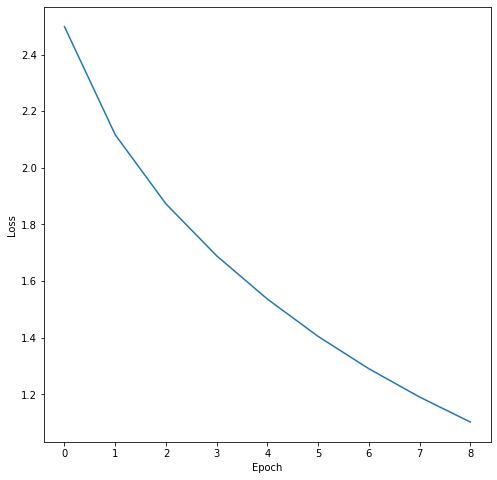

In [19]:
x = (range(0, 9))

plt.figure(figsize = (8, 8))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [20]:
model.eval() #also turns off batch norm

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [22]:
with torch.no_grad():
    
    correct = 0
    total = 0
    
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    y_test = y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print("Accuracy: ", accuracy_score(predicted, y_test))
    print("Precision: ", precision_score(predicted, y_test, average='weighted'))
    print("Recall: ", recall_score(predicted, y_test, average='weighted'))

torch.Size([10000, 16, 12, 12])
torch.Size([10000, 32, 4, 4])
torch.Size([10000, 512])
torch.Size([10000, 10])
Accuracy:  0.7838
Precision:  0.8102704377352453
Recall:  0.7838


# Future Predictions

In [23]:
print("sample target data = ", mnist_test_target.values[1005])

sample target data =  9


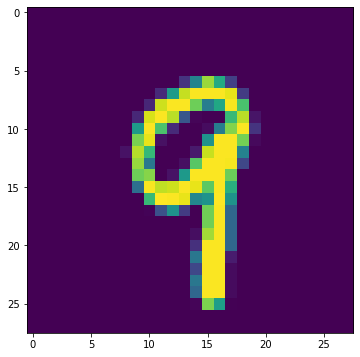

In [24]:
sample_img = mnist_test_features.values[1005]
sample_img = sample_img.reshape(1, 28, 28)

sample_img = sample_img[0, :, :]

plt.figure(figsize =(6, 6))
plt.imshow(sample_img)


In [25]:
sample = np.array(mnist_test_features.values[1005]) 

# create tensor and send it to device
sample_tensor = torch.from_numpy(sample).float()
sample_tensor = sample_tensor.reshape(-1, 1, 28, 28)
sample_tensor = sample_tensor.to(device) 

y_pred = model(sample_tensor)
print(y_pred)

_, predicted = torch.max(y_pred.data, -1)

print (" The predicted label is : ", predicted.item())

torch.Size([1, 16, 12, 12])
torch.Size([1, 32, 4, 4])
torch.Size([1, 512])
torch.Size([1, 10])
tensor([[-0.4880, -0.9562,  0.1608, -0.5884,  1.0530, -0.0247, -0.9057,  0.2945,
          1.9283,  2.4567]], grad_fn=<AddmmBackward0>)
 The predicted label is :  9
